In [1]:
# import librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

# Visualization
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import feature_extraction, linear_model, model_selection, preprocessing

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import words, stopwords, wordnet
from nltk.tokenize import RegexpTokenizer

from collections import Counter

# Import regex and time
import re
import time

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from gensim.models import Phrases

import emoji

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

# Disable deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#nltk.download('all')

f:\Ingenieur_IA\P6\cv_nlp\cv_nlp_venv\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


# NLP: modeling topics of dissatisfaction in Yelp restaurant reviews

In [2]:
df = pd.read_csv("bad_reviews.csv")

#### After cleaning our text in the previous notebook, we have a set of 32593 negative (1 or 2 star) reviews.

In [3]:
print(f"The dataframe is composed of {df.shape[0]} rows and {df.shape[1]} columns.")
df.head(5)

The dataframe is composed of 32593 rows and 2 columns.


,stars,text
0,1,"I went here when if first opened, and have nev..."
1,2,"Ordered Caramel frappe at Drive thru, BIG MIST..."
2,1,Food was great. But very disappointed with the...
3,1,Ordered an iced mocha and an iced white choco...
4,1,I'm a Barbecue judge and this ain't barbecue. ...


In [4]:
# Take sample of dataset

data = df.sample(n=10000, replace=False)
data = data.reset_index().drop(columns=["index", "stars"])

data.text.head(20)

0     Just ok. We were excited after we see the long...
1     I don't really know what to say.....mabye don'...
2     Don't waste your time. Not worth the wait in t...
3     With all fair restaurant reviews, normally it ...
4     Over charged, poor customer service they did n...
5     Ugh, there are times you could kick yourself. ...
6     The pizza isn't bad BUT the service is HORRIBL...
7     Sorry, but I do not like the food Here! I gave...
8     Horrible experience. Will be contacting the he...
9     Maxine's is a fun place but we've suffered a f...
10    The reviews for this place drove me here for S...
11    Don't ever get their Orange Juice! It is A L W...
12    Moved go the area and wanted to try this place...
13    The worst service - food was cold, appetizers ...
14    Extremely overpriced!!!! When u pay extra for ...
15    Order food and was told it would be ready in 2...
16    HORRID EXPERIENCE. this was our first time get...
17    Went here for lunch a few weeks back, had 

## Preprocessing the reviews

In [5]:
def display_tokens_info(tokens):
    print(f"nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}")
    print(tokens[:30])

In order to be able to analyze reviews for topics, or in other words perform a topic modeling, we will need to preprocess the text in the reviews. The technique chosen for this project is the following: 
1. Demojize the emojis, for example transform 🔥 into the word "fire
2. Transform each review into lowercase
3. Separate each review into a list of separate words or tokens (using a Regular Expressions tokenizer)
4. Remove all english language stop words
5. Lemmatize each review to remove for example conjugations (using the WordNet lemmatizer from NLTK), as lemmatization is preferred in this case for providing more readable words
6. Remove words shorter than 4 characters
7. Keep only nouns

In [6]:
stop_words = set(stopwords.words('english'))
stop_words.add('food')
lem = WordNetLemmatizer()
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')

def text_cleaner(text):

    text = emoji.demojize(text, delimiters=("", "")) # demojize the emojis in the docs

    text = text.lower() # to lowercase
    
    text = tokenizer.tokenize(text) # tokenize with regular expressions

    text = [w for w in text if w not in stop_words] # remove stopwords

    text = [lem.lemmatize(w) for w in text] # lemmatize with WordNetLemmatizer

    text = [w for w in text if len(w) > 3] # keep only words longer than 3 characters

    ### keep only nouns 

    pos_tag = nltk.pos_tag(text)
    noun_text = []

    for i in range (0, (len(text)-1)):

        if (pos_tag[i][1] == 'NN'):
            noun_text.append(pos_tag[i][0])

    text = noun_text

    ###

    return text

In [7]:
data["clean_text"] = data["text"].apply(lambda row : text_cleaner(row))

Our dataframe now looks like the following, with a separate column for the cleaned text:

In [8]:
data

,text,clean_text
0,Just ok. We were excited after we see the long...,"[line, corn, bread, seafood, gumbo, water, hal..."
1,I don't really know what to say.....mabye don'...,"[mabye, hype, trap, city, option, city, americ..."
2,Don't waste your time. Not worth the wait in t...,"[waste, time, line, heat, option, place, name,..."
3,"With all fair restaurant reviews, normally it ...","[restaurant, review, thing, price, thing, time..."
4,"Over charged, poor customer service they did n...","[customer, service, order, wait, refund, feel,..."
...,...,...
9995,Will not be returning. \n\nI ordered two burri...,"[bowl, daughter, quality, lady, counter, every..."
9996,Me and my brother come here for first time the...,"[brother, time, reception, door, call, call]"
9997,"Dear La Michoacana, a restaurant I used to lov...","[michoacana, restaurant, love, time, experienc..."
9998,Went here last night with a groupon. The first...,"[night, groupon, thing, glass, silverware, wai..."


## Before and after text preprocessing

In [9]:
corpus_original = wordpunct_tokenize(" ".join(data.text.values))
corpus_clean = np.concatenate(data.clean_text)

In [10]:
print(f"Unique tokens before cleaning: {len(set(corpus_original))}")
print(f"Unique tokens after cleaning: {len(set(corpus_clean))}")

Unique tokens before cleaning: 28780
Unique tokens after cleaning: 9663


### Corpus before cleaning

We see many stop words in the wordcloud and there are no useful words at all in the histogram representing word frequency.

In [11]:
display_tokens_info(corpus_original)

nb tokens 1387613, nb tokens uniques 28780
['Just', 'ok', '.', 'We', 'were', 'excited', 'after', 'we', 'see', 'the', 'long', 'line', 'earlier', 'in', 'the', 'day', ',', 'but', 'was', 'disappointed', '.', 'They', 'were', 'out', 'of', 'corn', 'bread', 'when', 'we', 'ordered']


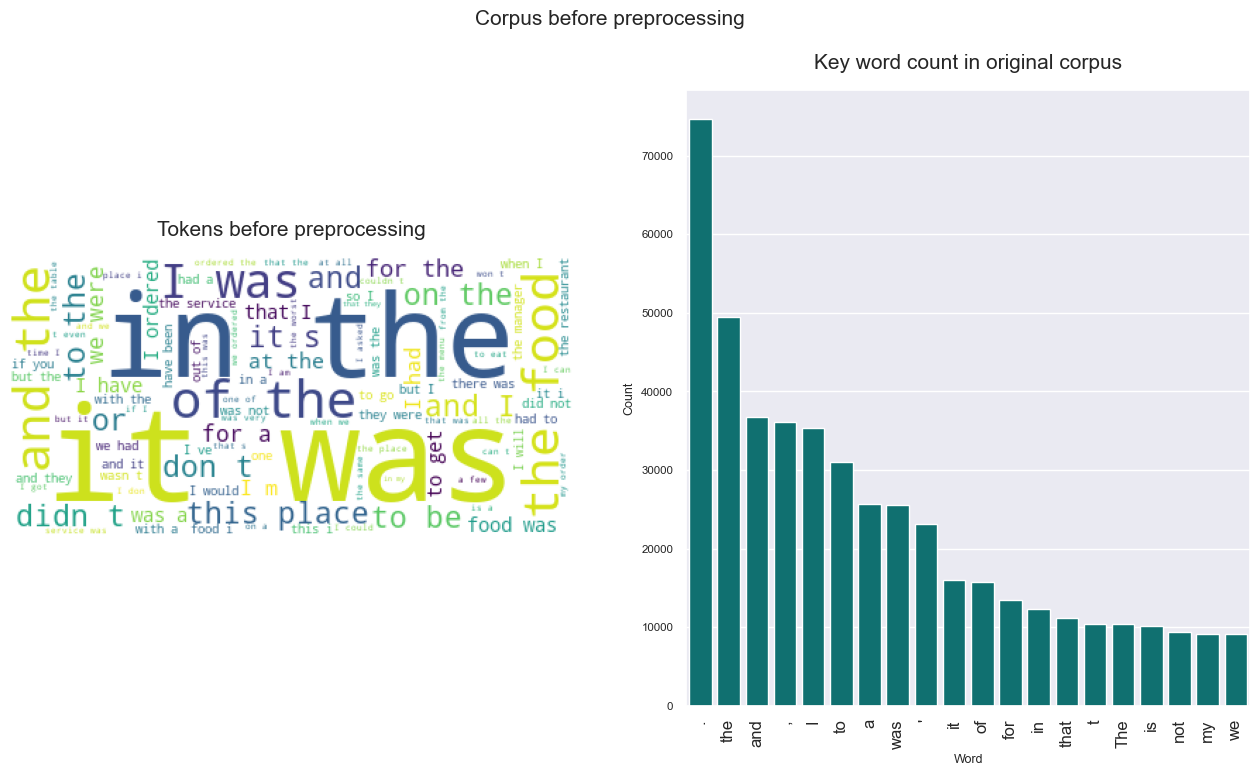

In [30]:
wordcloud = WordCloud(background_color='white',
                        stopwords=[],
                        max_words=100).generate(" ".join(corpus_original))

common_words = pd.DataFrame(Counter(corpus_original).most_common(20))
common_words.columns = ('Word', 'Count')

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.title("Tokens before preprocessing", fontsize=15, pad=15)
plt.axis("off")

plt.subplot(1,2,2)
sns.barplot(x=common_words['Word'], y=common_words['Count'], color='teal')
plt.xticks(rotation='vertical', fontsize=12)
plt.title("Key word count in original corpus", fontsize=15, pad=15)

plt.suptitle("Corpus before preprocessing", fontsize=15)

plt.show()


### Corpus after cleaning

We see a substantial improvement after preprocessing our reviews. The words in the word frequency histogram and the wordcloud are all restaurant-related and useful.

In [32]:
display_tokens_info(corpus_clean)

nb tokens 195446, nb tokens uniques 9663
['line' 'corn' 'bread' 'seafood' 'gumbo' 'water' 'half' 'ingredient'
 'bread' 'oyster' 'mabye' 'hype' 'trap' 'city' 'option' 'city' 'america'
 'beef' 'line' 'line' 'deal' 'minus' 'star' 'oyster' 'week' 'week' 'hell'
 'oyster' 'ruin' 'tasty']


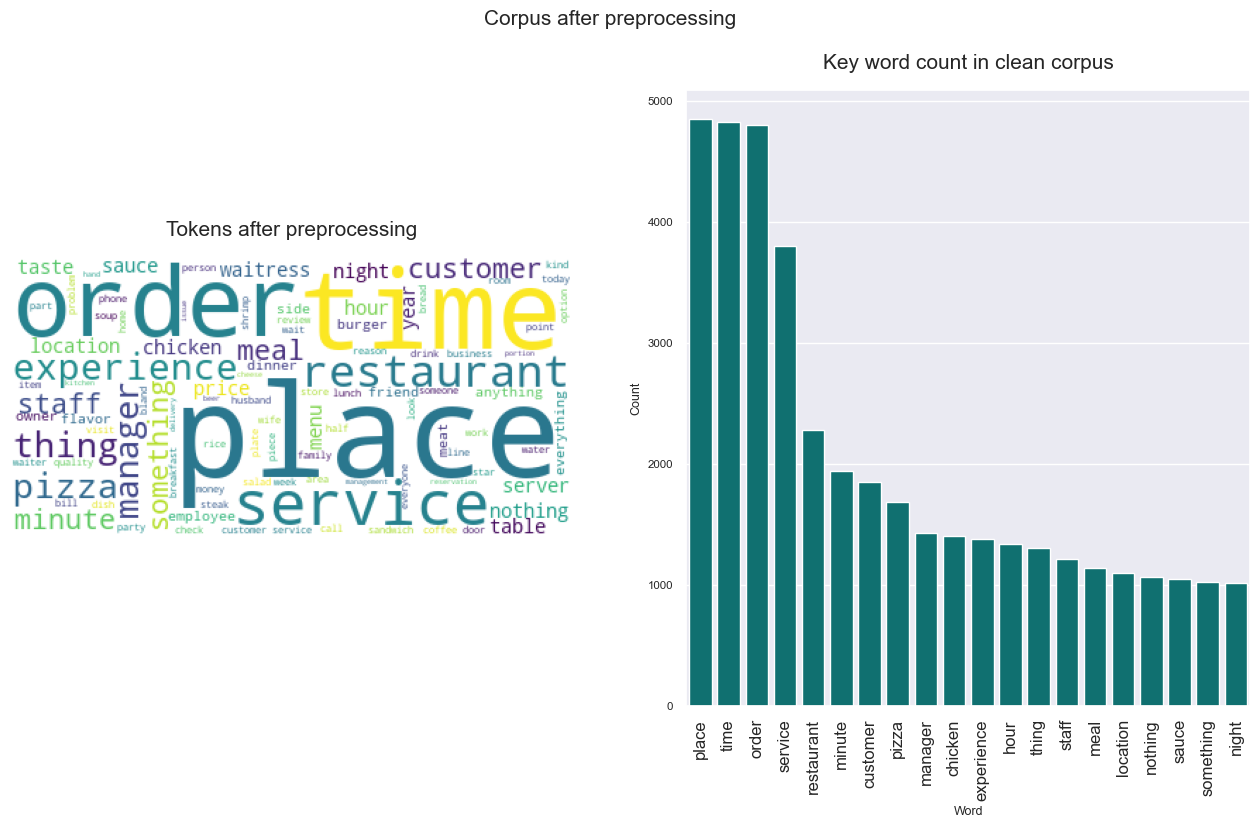

In [31]:
wordcloud = WordCloud(background_color='white',
                        stopwords=[],
                        max_words=100).generate(" ".join(corpus_clean))

common_words = pd.DataFrame(Counter(corpus_clean).most_common(20))
common_words.columns = ('Word', 'Count')

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.title("Tokens after preprocessing", fontsize=15, pad=15)
plt.axis("off")

plt.subplot(1,2,2)
sns.barplot(x=common_words['Word'], y=common_words['Count'], color='teal')
plt.xticks(rotation='vertical', fontsize=12)
plt.title("Key word count in clean corpus", fontsize=15, pad=15)

plt.suptitle("Corpus after preprocessing", fontsize=15)

plt.show()

## Train LDA model

The LDA or the Latent Dirichlet Allocation model will allow us to detect topics in our reviews, sets of words that cluster together and have a higher probability to appear together in a review.  

At first we will use a smaller sample of 1000 of the reviews in order to calculate the ideal number of topics, after which we will give our final model 5000 reviews to have the most precision in our topics.

In [32]:
data_sample = data.sample(n=1000, replace=False)
data_sample = data_sample.reset_index()
data_sample.drop(columns=['index'], inplace=True)

In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_sample.clean_text)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_sample.clean_text]

topics = []
coherence = []

for t in range(3, 7):

    lda = LdaModel( corpus=corpus, 
                    id2word=id2word, 
                    num_topics=t,
                    alpha=50/t,
                    eta=0.1,
                    per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda, texts=data_sample.clean_text, dictionary=id2word, coherence='c_v')
    # coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    
    topics.append(t)
    coherence.append(coherence_lda)

results = pd.DataFrame(columns=["Topics", "Coherence"])
results["Topics"] = topics
results["Coherence"] = coherence

In order to calculate the ideal number of topics, we check the coherence score of our model. We have the option of using u_mass coherence, which is faster computationally but less accurate or to use c_v, which is slower but more accurate. I decided to use a sample of 1000 reviews and calculate the c_v, which explains the apparently lower than expected score. If we were to take a larger sample size or use the whole dataset of reviews, our c_v score would be much higher.

In [33]:
ax = sns.lineplot(results, x=topics, y=coherence)
ax.set_title("Coherence score vs. number of topics", fontsize=15, pad=15)
ax.set_xlabel("Topics")
ax.set_ylabel("Coherence score (c_v)")

NameError: name 'results' is not defined

Now that we have decided on 4 topics, the area of the graph where we see a clear elbow, we will use our final LDA model with 5000 reviews.

## Topics observed by the LDA model:

In [37]:
data_sample = data.sample(n=5000, replace=False)
data_sample = data_sample.reset_index()
data_sample.drop(columns=['index'], inplace=True)

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_sample.clean_text)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_sample.clean_text]

lda = LdaModel(     corpus=corpus, 
                    id2word=id2word, 
                    num_topics=4,
                    chunksize=100, # number of documents to consider at once
                    minimum_probability=0.01, #  minimum probability of word in topic
                    passes=100, # how many times the algorithm passes over the whole corpus
                    alpha=50/4, # 
                    eta=0.1,
                    per_word_topics=True) # every word assigned a topic, otherwise omitted
lda.print_topics()

[(0,
  '0.096*"place" + 0.046*"restaurant" + 0.023*"nothing" + 0.023*"review" + 0.020*"something" + 0.020*"year" + 0.016*"owner" + 0.014*"water" + 0.014*"anything" + 0.012*"business"'),
 (1,
  '0.029*"chicken" + 0.024*"meal" + 0.021*"sauce" + 0.021*"taste" + 0.019*"thing" + 0.018*"menu" + 0.018*"meat" + 0.018*"flavor" + 0.016*"salad" + 0.015*"side"'),
 (2,
  '0.098*"time" + 0.082*"service" + 0.038*"minute" + 0.037*"customer" + 0.031*"hour" + 0.028*"manager" + 0.027*"experience" + 0.022*"night" + 0.022*"staff" + 0.020*"waitress"'),
 (3,
  '0.115*"order" + 0.041*"pizza" + 0.024*"location" + 0.023*"price" + 0.023*"star" + 0.022*"money" + 0.021*"burger" + 0.015*"home" + 0.014*"person" + 0.014*"phone"')]

### pyLDAvis visualization of the intertopic distance and top-30 most relevant terms per topic

In [40]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

f:\Ingenieur_IA\P6\cv_nlp\cv_nlp_venv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.104901 -0.388239       1        1  25.357708
2      0.316552  0.224959       2        1  25.207681
1     -0.118937  0.103008       3        1  25.069770
3     -0.302516  0.060272       4        1  24.364842, topic_info=           Term         Freq        Total Category  logprob  loglift
50        order  2758.000000  2758.000000  Default  30.0000  30.0000
51        place  2395.000000  2395.000000  Default  29.0000  29.0000
53         time  2455.000000  2455.000000  Default  28.0000  28.0000
24      service  2036.000000  2036.000000  Default  27.0000  27.0000
63   restaurant  1151.000000  1151.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
515        girl   158.125839   158.433706   Topic4  -5.0215   1.4101
149        deal   157.975482   158.283344   Topic4  -5.0225   1.4101
121      worker   147.004070   147.311931   Topic4  -5.0944   1.4099
98         help   144.205386   144.513253   Topic4  -5.1137   1.4099
259       lunch   308.115988   312.176502   Topic4  -4.3544   1.3989

[156 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
10        1  0.996135    anyone
290       1  0.867674  anything
290       2  0.132357  anything
171       1  0.997490      area
825       4  0.997531      beer
...     ...       ...       ...
93        1  0.999147      wife
536       2  0.999932     woman
558       4  0.998531      work
121       4  0.997883    worker
29        1  0.999843      year

[131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

### WordClouds per topic

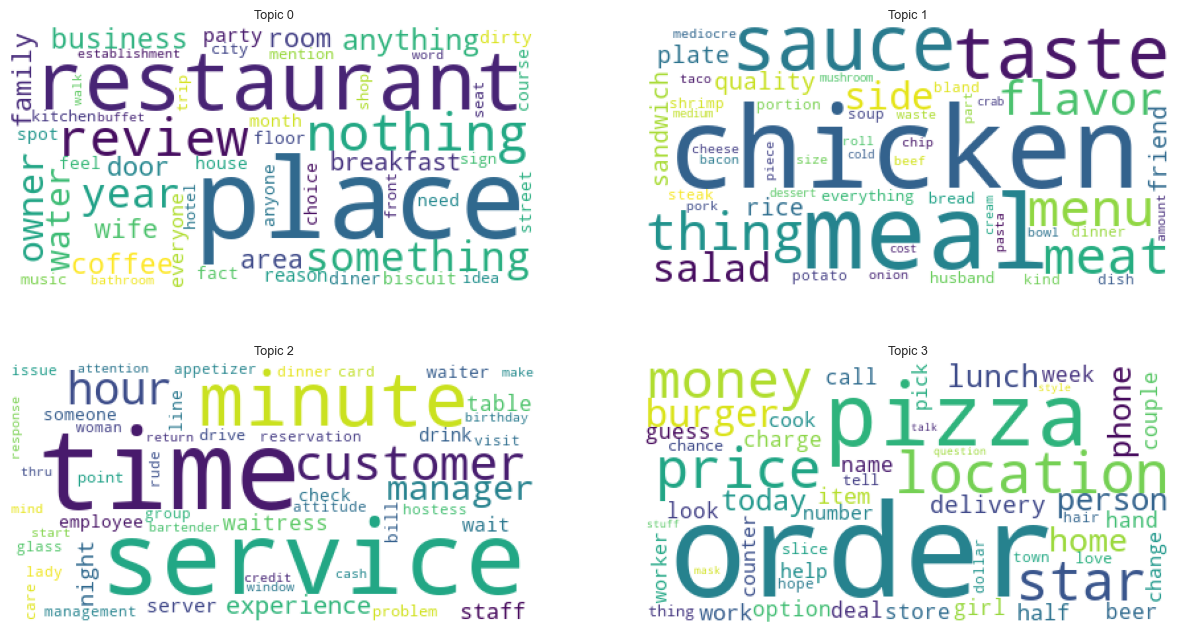

In [41]:
nbr_rows = int(lda.num_topics/2) if lda.num_topics % 2 == 0 else int((lda.num_topics+1)/2)
index = 1

fig, axs = plt.subplots(nbr_rows, 2, figsize=(15,4*nbr_rows))

for t in range(lda.num_topics):
    plt.subplot(nbr_rows, 2, index)
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(lda.show_topic(t, 50))))
    plt.axis("off")
    plt.title("Topic " + str(t))

    index+=1

plt.show()

## Conclusion

We can see four clear topics emerge: 

1. Insatisfaction about the restaurant, the place itself.
2. Insatisfaction about the food, the taste, the flavor, the meal.
3. Insatisfaction about the service, many time words such as hour and minute indicate that maybe the service was too slow. The experience, the management, the staff.
4. Problems with the order, the location, the price/money.